In [1]:
import sys
sys.path.append("../")

# Look at PPI data

In [6]:
import torch
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, InMemoryDataset, DataLoader, Batch, Dataset

# Load the PPI dataset
train_dataset = PPI(root='/tmp/PPI', split='train')
val_dataset = PPI(root='/tmp/PPI', split='val')
test_dataset = PPI(root='/tmp/PPI', split='test')


In [7]:
from torch_geometric.utils import k_hop_subgraph

In [8]:
class SubgraphDataset(Dataset):
    def __init__(self, base_dataset, num_hops, num_subgraphs_per_graph):
        super(SubgraphDataset, self).__init__()
        self.base_dataset = base_dataset
        self.num_hops = num_hops
        self.num_subgraphs_per_graph = num_subgraphs_per_graph
        self.subgraphs = self.create_subgraphs()

    def create_subgraphs(self):
        subgraphs = []
        for data in self.base_dataset:
            num_nodes = data.num_nodes
            for _ in range(self.num_subgraphs_per_graph):
                # Randomly select a central node
                central_node = torch.randint(0, num_nodes, (1,)).item()
                # Extract the k-hop subgraph
                subgraph_nodes, subgraph_edge_index, _, _ = k_hop_subgraph(
                    central_node, self.num_hops, data.edge_index, relabel_nodes=True
                )
                subgraph = Data(
                    x=data.x[subgraph_nodes],
                    edge_index=subgraph_edge_index,
                    y=data.y if data.y.dim() == 0 else data.y[subgraph_nodes]
                )
                subgraphs.append(subgraph)
        return subgraphs

    def len(self):
        return len(self.subgraphs)

    def get(self, idx):
        return self.subgraphs[idx]

In [16]:
train_dataset = SubgraphDataset(train_dataset, 2, 5)
for train in train_dataset:
    print(train)
    

Data(x=[287, 50], edge_index=[2, 2760], y=[287, 121])
Data(x=[287, 50], edge_index=[2, 2760], y=[287, 121])
Data(x=[287, 50], edge_index=[2, 2760], y=[287, 121])
Data(x=[287, 50], edge_index=[2, 2760], y=[287, 121])
Data(x=[287, 50], edge_index=[2, 2760], y=[287, 121])
Data(x=[932, 50], edge_index=[2, 25966], y=[932, 121])
Data(x=[504, 50], edge_index=[2, 10928], y=[504, 121])
Data(x=[602, 50], edge_index=[2, 17628], y=[602, 121])
Data(x=[745, 50], edge_index=[2, 22026], y=[745, 121])
Data(x=[31, 50], edge_index=[2, 196], y=[31, 121])
Data(x=[287, 50], edge_index=[2, 2760], y=[287, 121])
Data(x=[18, 50], edge_index=[2, 54], y=[18, 121])
Data(x=[162, 50], edge_index=[2, 3164], y=[162, 121])
Data(x=[287, 50], edge_index=[2, 2760], y=[287, 121])
Data(x=[132, 50], edge_index=[2, 2274], y=[132, 121])
Data(x=[537, 50], edge_index=[2, 14758], y=[537, 121])
Data(x=[393, 50], edge_index=[2, 10624], y=[393, 121])
Data(x=[245, 50], edge_index=[2, 6144], y=[245, 121])
Data(x=[545, 50], edge_index=

In [17]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)

/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Training

In [18]:
%load_ext autoreload
%autoreload 2

In [19]:
class GNNConfig:
    input_dim: int = 2000
    hidden_dims: tuple = (128,)
    conv_dim: int = 50
    out_dim: int = 20
    latent_dim: int = 64
    num_graphs: int = 6

In [20]:
class TrainerConfig:
    lr: float = 0.001
    weight_decay: float = 1e-4
    max_grad: float = 20.0
    num_epochs: int = 100
    alpha: float = 0.001 # graph smoothness regularization weight
    beta: float = 0.001 # attention weight sparsity regularization weight
    lambda_l1: float = 0.001
    lambda_l2: float = 0.001
    verbose: bool = True
    train_loss: list = []
    val_loss: list = []

In [21]:
gnn_config = GNNConfig()
gnn_config.input_dim = 50
gnn_config.hidden_dims = (128, 128, 128)
gnn_config.conv_dim = 128
gnn_config.out_dim = 121

In [22]:
train_config = TrainerConfig()
train_config.lr = 1e-4
train_config.num_epochs = 1
train_config.max_grad = 1000.0
train_config.weight_decay = 1e-4
train_config.alpha = 0.001
train_config.verbose = True
train_config.lambda_l1 = 0.01
train_config.lambda_l2 = 0.01

In [23]:
from scGraphLLM.train import GNN_Trainer

In [24]:
device = 'mps'
torch.set_default_device('mps')

In [25]:
trainer = GNN_Trainer(train_dataset, val_dataset, gnn_config, train_config)

Number of GNN layers:  5
Number of Batch Normalization layers:  4


In [26]:
trainer.device

device(type='mps')

In [27]:
if torch.backends.mps.is_available():
    torch.set_default_tensor_type(torch.FloatTensor)
    torch.backends.mps.device = torch.device('mps')

/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/torch/__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [28]:
if torch.backends.mps.is_available():
    torch.set_default_tensor_type(torch.FloatTensor)
    torch.backends.mps.device = torch.device('mps')
    torch.default_generator = torch.Generator(device='mps')

In [29]:
model, A, H, Attn, loss_train, loss_val = trainer.train_loop()

  0%|          | 0/20000 [00:00<?, ?it/s]/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/torch/utils/_device.py:77: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return func(*args, **kwargs)
  0%|          | 0/20000 [00:00<?, ?it/s]


RuntimeError: t() expects a tensor with <= 2 dimensions, but self is 3D

In [17]:
import matplotlib.pyplot as plt
import numpy as np

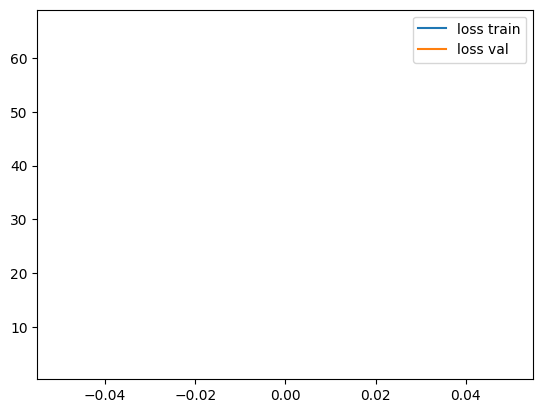

In [18]:
plt.plot(np.clip(loss_train, None, loss_train[0]), label='loss train')
plt.plot(np.clip(loss_val, None, loss_val[0]), label='loss val')
plt.legend()
plt.show()

In [19]:
data_list = [val for val in val_dataset]
data_list

[Data(x=[3230, 50], edge_index=[2, 97446], y=[3230, 121]),
 Data(x=[3284, 50], edge_index=[2, 101474], y=[3284, 121])]

In [20]:
A_final = A[-1]

In [21]:
A_final

tensor([[0.0000, 0.0722, 0.0892,  ..., 0.0000, 0.0000, 0.0000],
        [0.0366, 0.0000, 0.0366,  ..., 0.0000, 0.0000, 0.0000],
        [0.0446, 0.0433, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0371, 0.0366, 0.0371,  ..., 0.0000, 0.0000, 0.0000],
        [0.0770, 0.0677, 0.0770,  ..., 0.0000, 0.0000, 0.0000],
        [0.0371, 0.0366, 0.0371,  ..., 0.0000, 0.0000, 0.0000]],
       device='mps:0', grad_fn=<MulBackward0>)

In [22]:
data_one_graph = data_list[0]
learned_graph = A_final[:3230, :3230]
learned_graph.shape

torch.Size([3230, 3230])

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx, dense_to_sparse

In [24]:
data_one_graph

Data(x=[3230, 50], edge_index=[2, 97446], y=[3230, 121])

/var/folders/n0/lbm2yq4n3r1gp83zkf5s69j00000gn/T/ipykernel_37376/3984777032.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


[0, 1, 3, 2, 5, 4, 8, 15, 6, 7, 9, 10, 12, 11, 13, 14, 16, 17, 18, 19]


NetworkXError: Node 0 has no position.

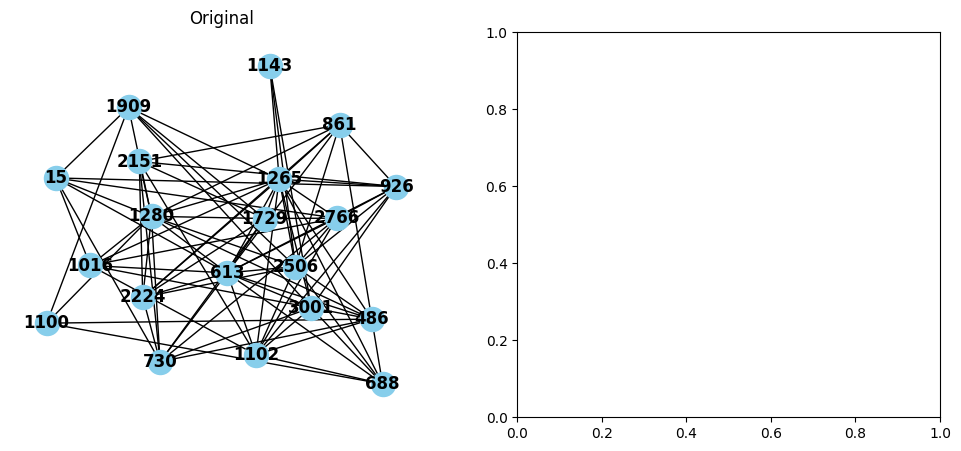

In [28]:
from matplotlib.colors import LinearSegmentedColormap
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()
cmap = plt.cm.get_cmap('viridis')

data = data_one_graph
G = to_networkx(data, to_undirected=True)
centrality = nx.degree_centrality(G)
top_nodes = sorted(centrality, key=centrality.get, reverse=True)[:20]
H = G.subgraph(top_nodes)
pos = nx.spring_layout(H, k=2)
nx.draw(H, ax=axes[0], pos=pos, with_labels=True, node_color='skyblue', node_size=300, font_weight='bold', width=1)
axes[0].set_title("Original")

learned, w_learned = dense_to_sparse(learned_graph)
edges = list(zip(learned[0].detach().cpu().numpy(), learned[1].detach().cpu().numpy()))
G2 = nx.Graph()
G2.add_edges_from(edges)
edge_weights = [w_learned[j].item() for j in range(w_learned.size(0))]

centrality = nx.degree_centrality(G2)
top_nodes = sorted(centrality, key=centrality.get, reverse=True)[:20]
print(top_nodes)
H2 = G2.subgraph(top_nodes)
nx.draw(H2, pos=pos, ax=axes[1], with_labels=True, node_color='skyblue', node_size=300, 
        font_weight='bold', width=1)
axes[1].set_title("Learned")


# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [29]:
Attn[-1].shape

torch.Size([13028, 50, 50])